# Beverages retail sales Forecasting

**Background** 

The dataset was provided by a large beverage company in Australia. They sell their products through various supermarkets and also engage into heavy promotions throughout the year. Their demand is also influenced by various factors like holiday, seasonality. They needed a forecast of each of the products (6 products in total) at item level every week in weekly buckets.

**Area of Investigation**

1. Trend
2. Seasonality
3. Serial dependence
4. Machine Learning on the time series data

## 1. Data Understanding and Preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.linear_model import LinearRegression
import datetime

In [2]:
df = pd.read_csv('retail_data.csv')

In [3]:
df.shape

(1218, 12)

In [4]:
df.head()

,Product,date,Sales,Price Discount (%),In-Store Promo,Catalogue Promo,Store End Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
0,SKU1,2/5/2017,27750,0%,0,0,0,0.0,0,0,0,0
1,SKU1,2/12/2017,29023,0%,1,0,1,0.0,0,1,0,0
2,SKU1,2/19/2017,45630,17%,0,0,0,0.0,0,0,0,0
3,SKU1,2/26/2017,26789,0%,1,0,1,0.0,0,0,0,0
4,SKU1,3/5/2017,41999,17%,0,0,0,0.0,0,0,0,0


### 1.1 Check data types

In [5]:
df.dtypes

Product                object
date                   object
Sales                   int64
Price Discount (%)     object
In-Store Promo          int64
Catalogue Promo         int64
Store End Promo         int64
Google_Mobility       float64
Covid_Flag              int64
V_DAY                   int64
EASTER                  int64
CHRISTMAS               int64
dtype: object

In [6]:
df['date'] = pd.to_datetime(df['date'])

In [7]:
df.dtypes

Product                       object
date                  datetime64[ns]
Sales                          int64
Price Discount (%)            object
In-Store Promo                 int64
Catalogue Promo                int64
Store End Promo                int64
Google_Mobility              float64
Covid_Flag                     int64
V_DAY                          int64
EASTER                         int64
CHRISTMAS                      int64
dtype: object

In [8]:
df['Price Discount (%)'] = [x.replace('%', '') for x in df['Price Discount (%)']]
df['Price Discount (%)'] = df['Price Discount (%)'].astype('int64')

In [9]:
df.dtypes

Product                       object
date                  datetime64[ns]
Sales                          int64
Price Discount (%)             int64
In-Store Promo                 int64
Catalogue Promo                int64
Store End Promo                int64
Google_Mobility              float64
Covid_Flag                     int64
V_DAY                          int64
EASTER                         int64
CHRISTMAS                      int64
dtype: object

All data types are correct

### 1.2 Check missing values

In [10]:
df.apply(lambda x: sum(x.isnull()),axis=0)

Product               0
date                  0
Sales                 0
Price Discount (%)    0
In-Store Promo        0
Catalogue Promo       0
Store End Promo       0
Google_Mobility       0
Covid_Flag            0
V_DAY                 0
EASTER                0
CHRISTMAS             0
dtype: int64

No missing values were found

### 1.3 Rename the columns

In [11]:
df.columns = [c.replace(' ', '_') for c in df.columns]
df = df.rename(columns = {'In-Store_Promo' : 'In_Store_Promo'})
df.columns

Index(['Product', 'date', 'Sales', 'Price_Discount_(%)', 'In_Store_Promo',
       'Catalogue_Promo', 'Store_End_Promo', 'Google_Mobility', 'Covid_Flag',
       'V_DAY', 'EASTER', 'CHRISTMAS'],
      dtype='object')

### 1.4 Check for outliers

<Axes: xlabel='Sales', ylabel='Product'>

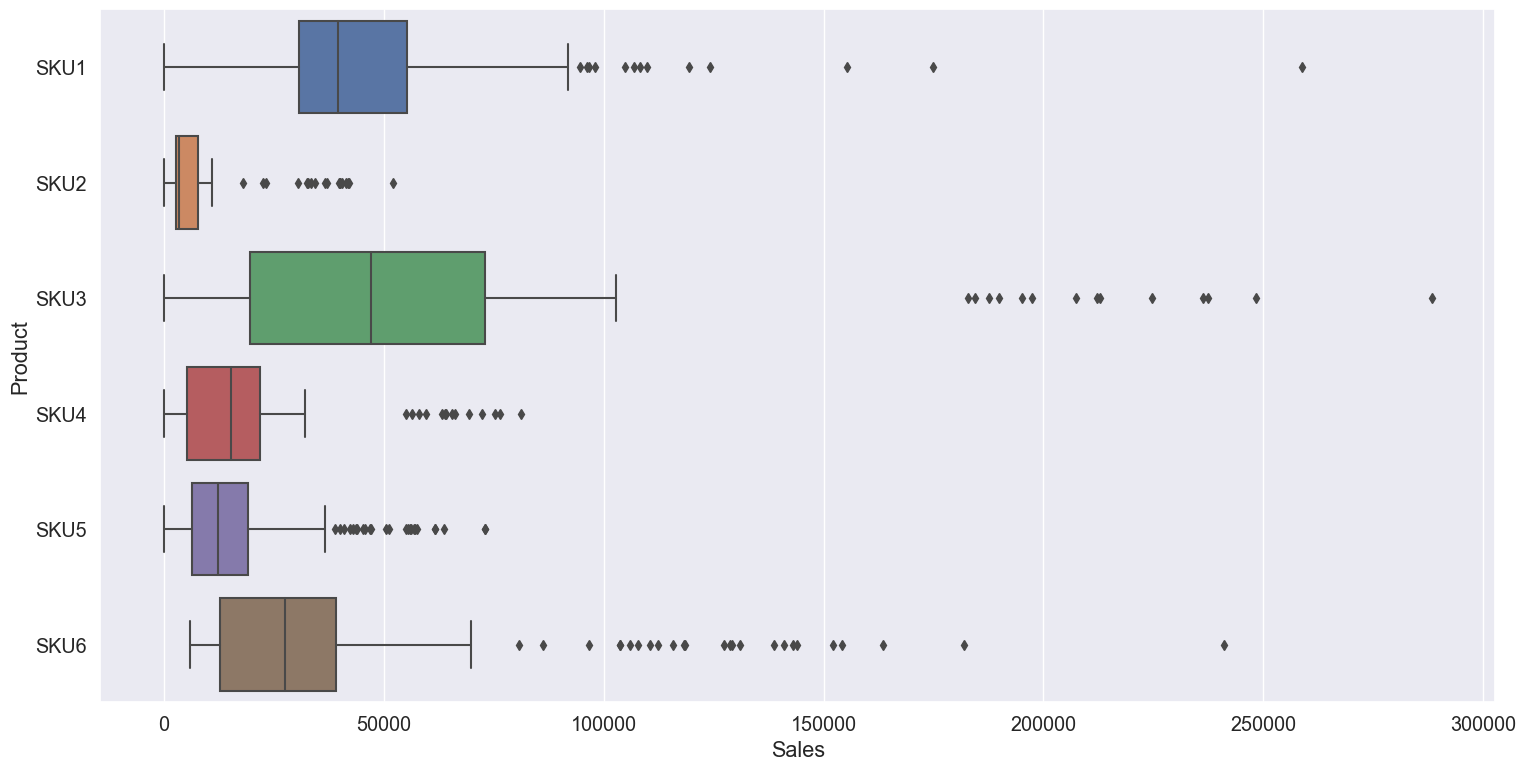

In [12]:
plt.figure(figsize=(18,9))
sns.set(font_scale = 1.3)
sns.boxplot(data = df, y = 'Product', x = "Sales", dodge=False)

According to the graphs, there are products with `Sales` equals to zero. It is believed that the data needed to be predicted is mixed into the data set after checking the data.

In [13]:
# Separate the test data
df_test = df[df.Sales == 0]

It is noticed that the tested data of SKU6 is missing. 

In [14]:
# remove the 0 Sales rows
df = df.drop(df[df.Sales == 0].index)

<Axes: xlabel='Sales', ylabel='Product'>

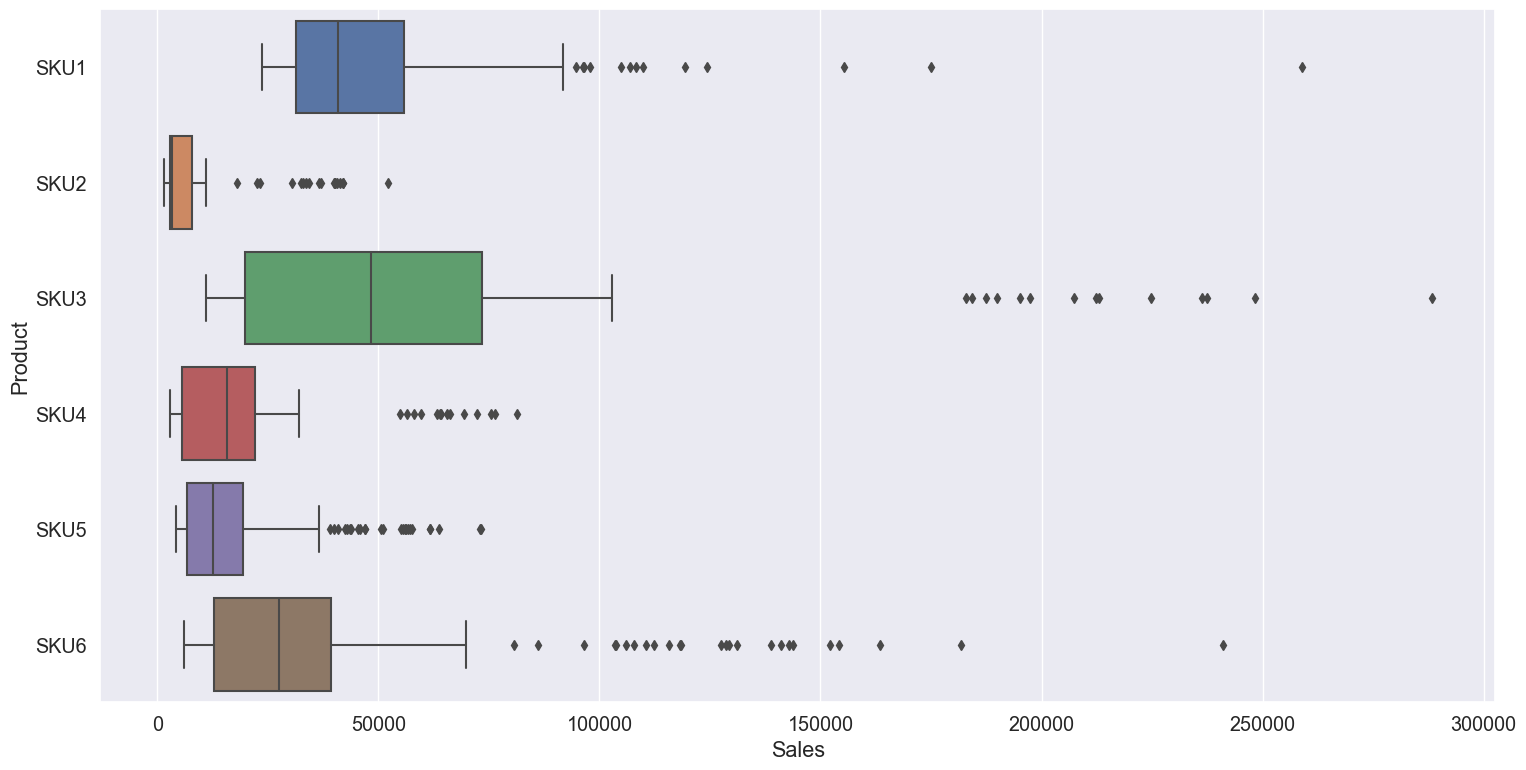

In [15]:
plt.figure(figsize=(18,9))
sns.set(font_scale = 1.3)
sns.boxplot(data = df, y = 'Product', x = "Sales", dodge=False)

After removing the `Sales` equal to zero, there are still some outliers in the `Sales` feature. But since we do not have enough information on the components for the sales, it is not appropriate to treat it as an outlier.

## 2. Exploratory Data Analysis

### 2.1 Data description

In [16]:
round(df.describe(),2)

,date,Sales,Price_Discount_(%),In_Store_Promo,Catalogue_Promo,Store_End_Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
count,1188,1188.00,1188.00,1188.00,1188.00,1188.00,1188.00,1188.00,1188.00,1188.00,1188.00
mean,2018-12-26 12:00:00,31059.70,24.71,0.47,0.21,0.35,-2.28,0.21,0.02,0.02,0.02
min,2017-02-05 00:00:00,1453.00,0.00,0.00,0.00,0.00,-28.49,0.00,0.00,0.00,0.00
25%,2018-01-14 00:00:00,7695.25,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,2018-12-26 12:00:00,20547.00,25.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,2019-12-08 00:00:00,40978.00,40.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
max,2020-11-15 00:00:00,288322.00,83.00,1.00,1.00,1.00,3.90,1.00,1.00,1.00,1.00
std,NaN,35135.66,21.32,0.50,0.41,0.48,5.84,0.41,0.14,0.14,0.12


### 2.2 Data visualisation

In [17]:
df = df.set_index('date')

In [18]:
df['Product'].unique()

array(['SKU1', 'SKU2', 'SKU3', 'SKU4', 'SKU5', 'SKU6'], dtype=object)

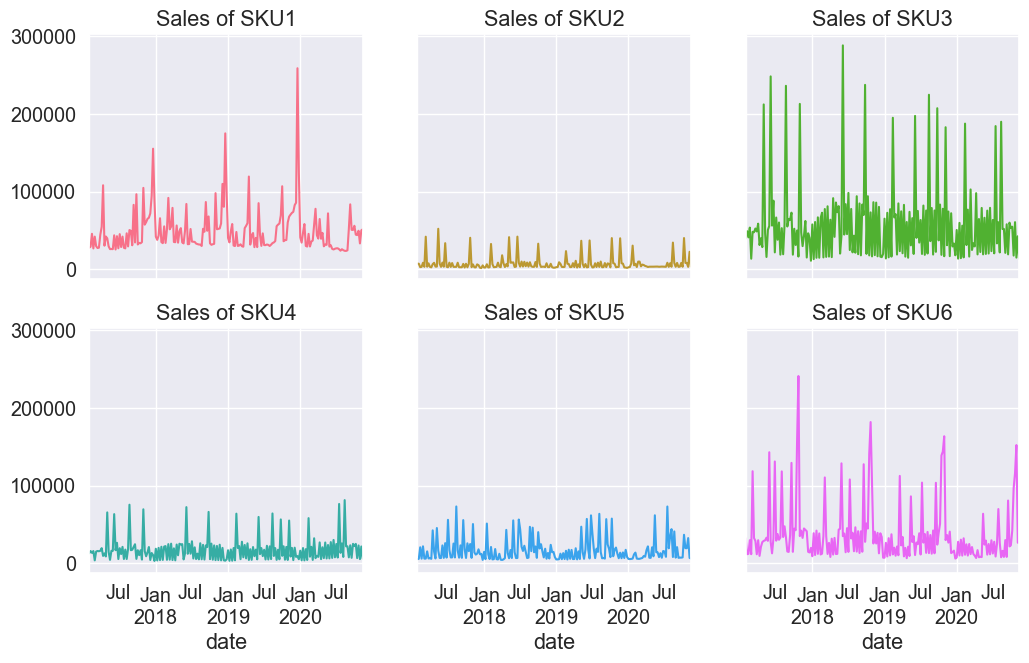

In [19]:
fig, ax = plt.subplots(2, 3, figsize = (12, 7), sharex = True, sharey = True)
palette = sns.color_palette("husl", n_colors=df['Product'].nunique())

for i, c in enumerate(palette):
    product_name = f"SKU{str(i+1)}"
    df.query('Product == @product_name') \
        .Sales \
        .plot(ax = ax[i // 3][i % 3], color = c, title = f"Sales of {product_name}")
    


### 2.3 Correlation

In [20]:
df_corr = df.corr(numeric_only=True)
df_corr

,Sales,Price_Discount_(%),In_Store_Promo,Catalogue_Promo,Store_End_Promo,Google_Mobility,Covid_Flag,V_DAY,EASTER,CHRISTMAS
Sales,1.000000,0.432887,0.252071,-0.124398,0.234811,0.044885,-0.047748,-0.011653,-0.013495,-0.013893
Price_Discount_(%),0.432887,1.000000,0.225429,-0.091492,0.234464,-0.207491,0.265120,-0.042953,0.003640,-0.035163
In_Store_Promo,0.252071,0.225429,1.000000,-0.488728,0.367410,0.060471,-0.038873,0.020951,0.020951,0.021550
Catalogue_Promo,-0.124398,-0.091492,-0.488728,1.000000,0.124778,0.075202,-0.098381,-0.045466,-0.045466,0.036468
Store_End_Promo,0.234811,0.234464,0.367410,0.124778,1.000000,0.082501,-0.067667,0.019489,-0.068211,0.009620
Google_Mobility,0.044885,-0.207491,0.060471,0.075202,0.082501,1.000000,-0.764376,0.076392,-0.111869,0.048450
Covid_Flag,-0.047748,0.265120,-0.038873,-0.098381,-0.067667,-0.764376,1.000000,0.015213,0.015213,-0.063385
V_DAY,-0.011653,-0.042953,0.020951,-0.045466,0.019489,0.076392,0.015213,1.000000,-0.020619,-0.017810
EASTER,-0.013495,0.003640,0.020951,-0.045466,-0.068211,-0.111869,0.015213,-0.020619,1.000000,-0.017810
CHRISTMAS,-0.013893,-0.035163,0.021550,0.036468,0.009620,0.048450,-0.063385,-0.017810,-0.017810,1.000000


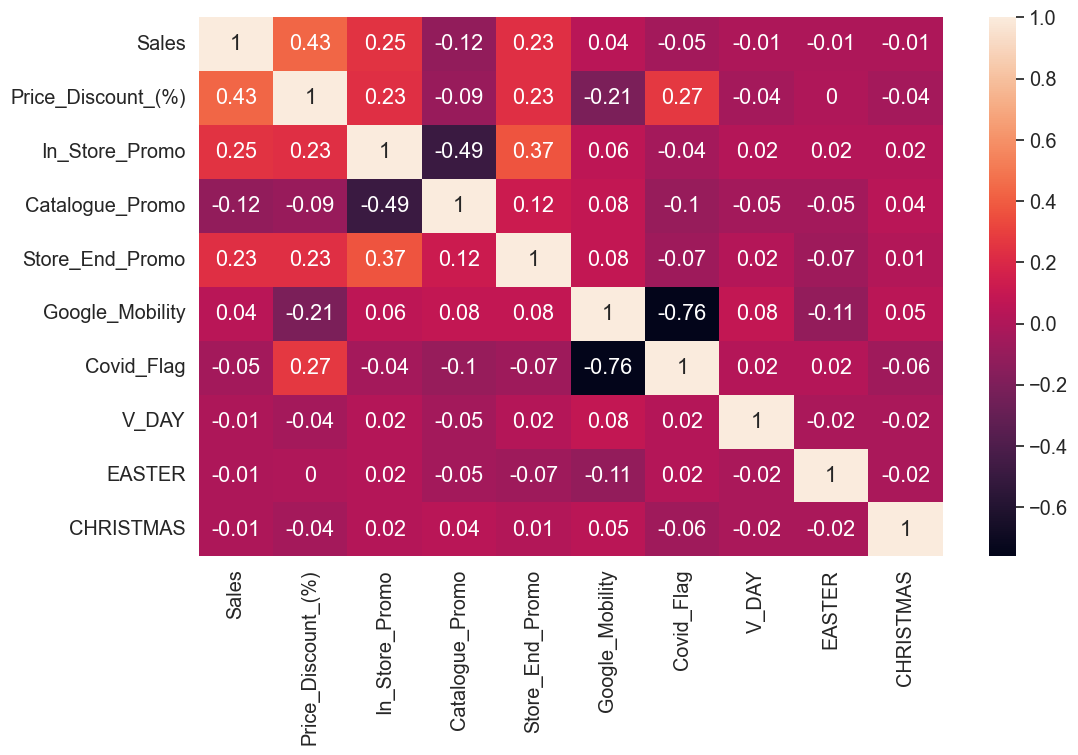

In [21]:
fig, ax = plt.subplots(figsize = (12, 7))
ax = sns.heatmap(data = round(df_corr, 2),
           annot =True)

From the heatmap, we see that `Google_Mobility` has an inverse correlation with `Covid_Flag`. `In_Store_Promo` is slightly correlated with `Catalogue_Promo` and also for `Sales` and `Price_Discount_(%)`. 

### 2.4 Seasonal Decomposition


In [155]:
# Split the 6 SKUs to different dataset
df_group = df.reset_index().groupby('Product')

# save them in dictionary
skus = {'sku1' : df_group.get_group("SKU1").set_index('date'),
    'sku2' : df_group.get_group("SKU2").set_index('date'),
    'sku3' : df_group.get_group("SKU3").set_index('date'),
    'sku4' : df_group.get_group("SKU4").set_index('date'),
    'sku5' : df_group.get_group("SKU5").set_index('date'),
    'sku6' : df_group.get_group("SKU6").set_index('date')}


In [26]:
def seasonal_decompose(y, axes, i, key):
    res = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    res.observed.plot(ax=axes[0+i*4], legend=False, title = key.upper())
    axes[0+i*4].set_ylabel('Observed')
    res.trend.plot(ax=axes[1+i*4], legend=False)
    axes[1+i*4].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2+i*4], legend=False)
    axes[2+i*4].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3+i*4], legend=False)
    axes[3+i*4].set_ylabel('Residual')

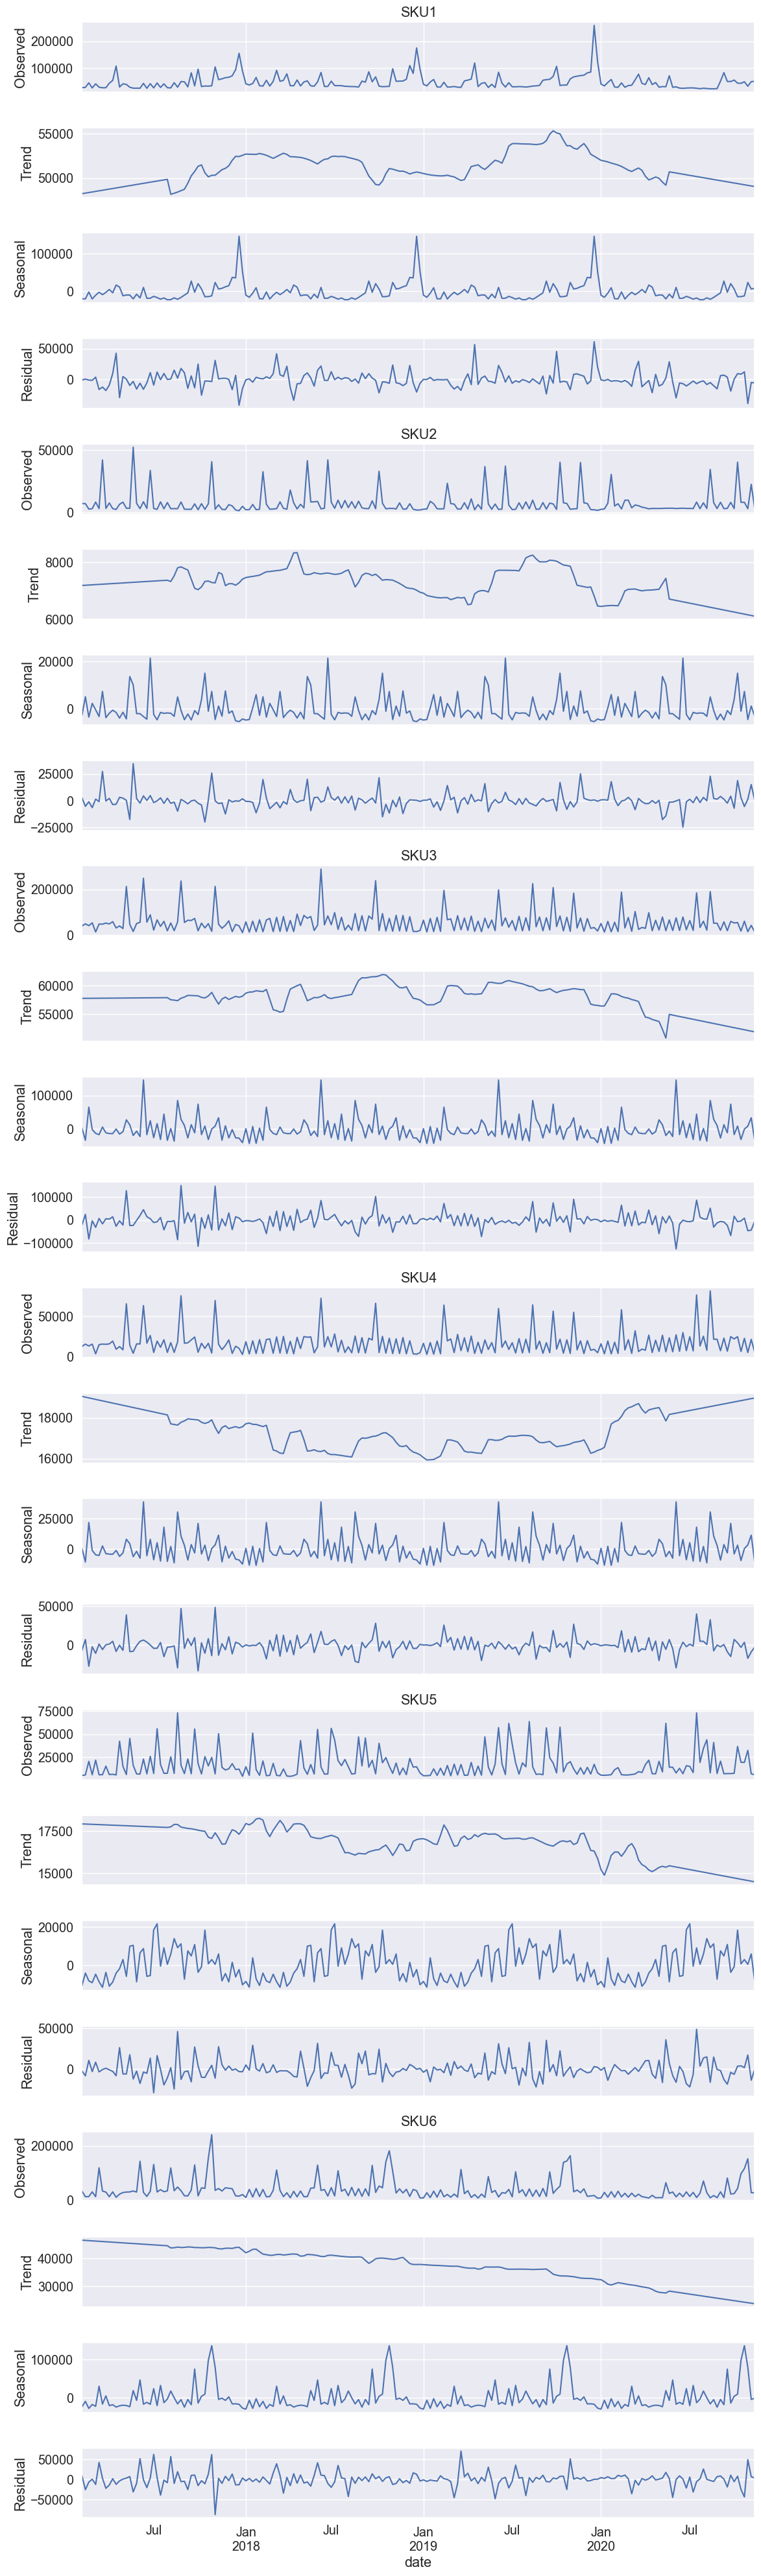

In [34]:
fig, ax = plt.subplots(ncols=1, nrows=24, sharex = True, figsize = (12, 40))


for i, (key, sku) in enumerate(skus.items()):
    seasonal_decompose(sku.Sales, ax, i, key)


plt.tight_layout()
plt.show()

### 2.5 Stationarity

In [39]:
# plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, label):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= label)
    ax.set_title(label)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std');
    ax.legend()

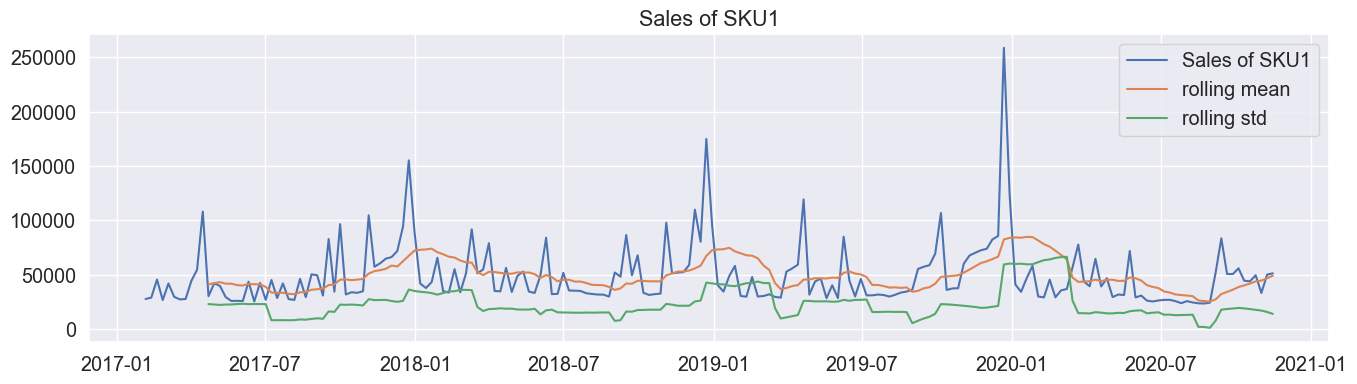

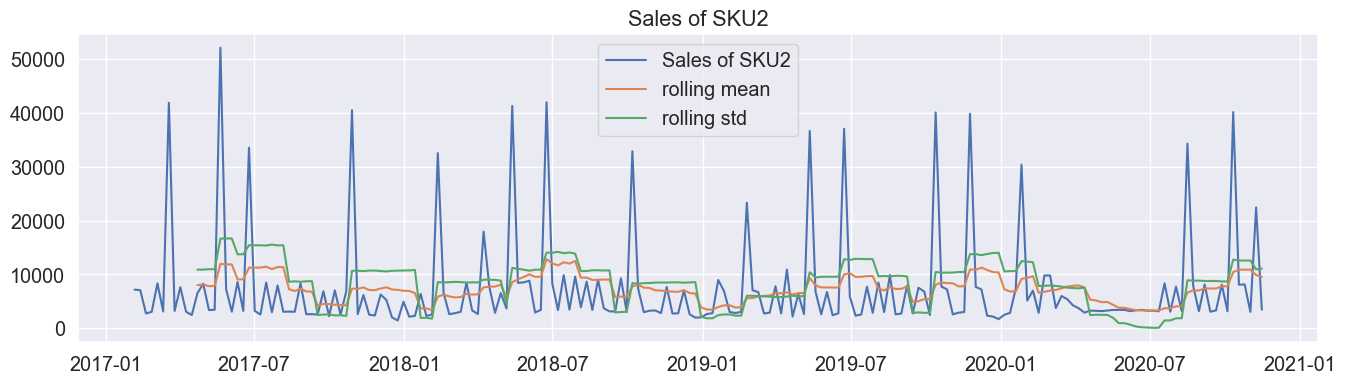

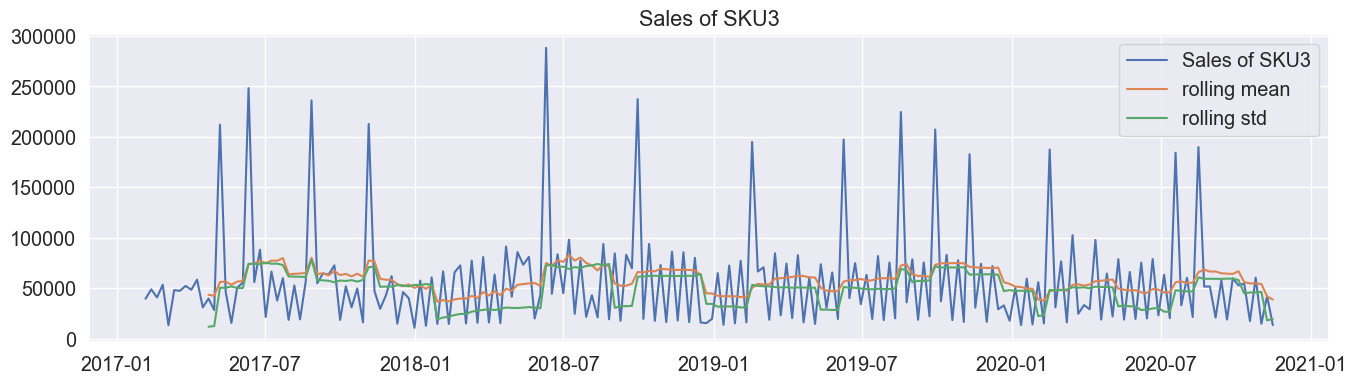

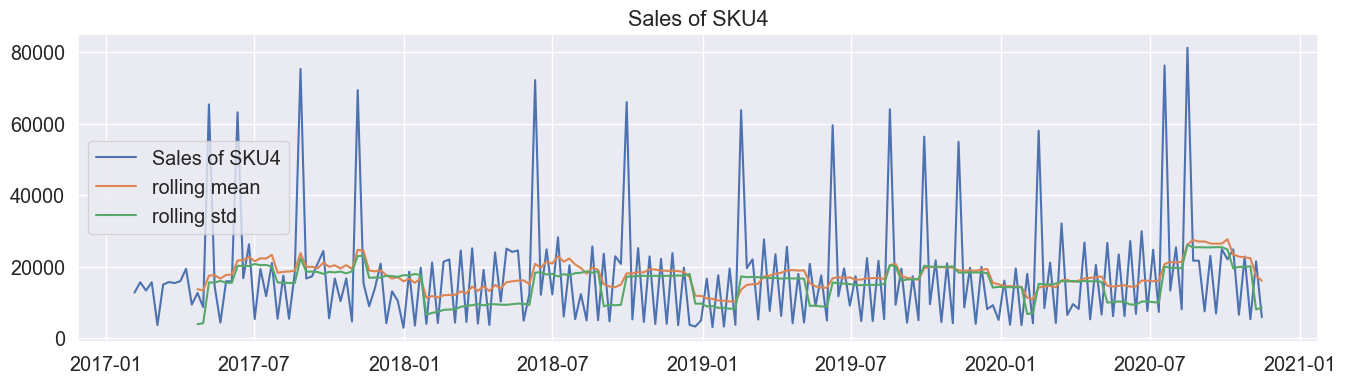

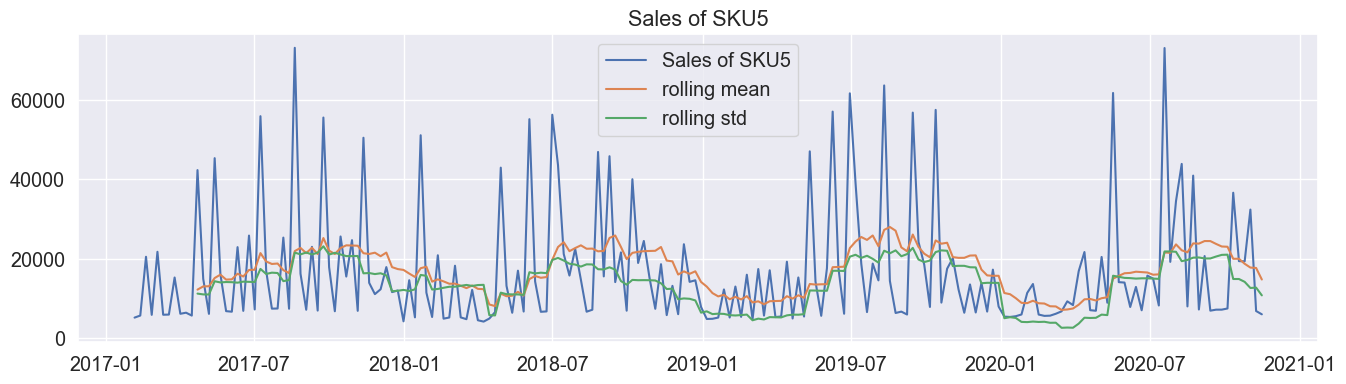

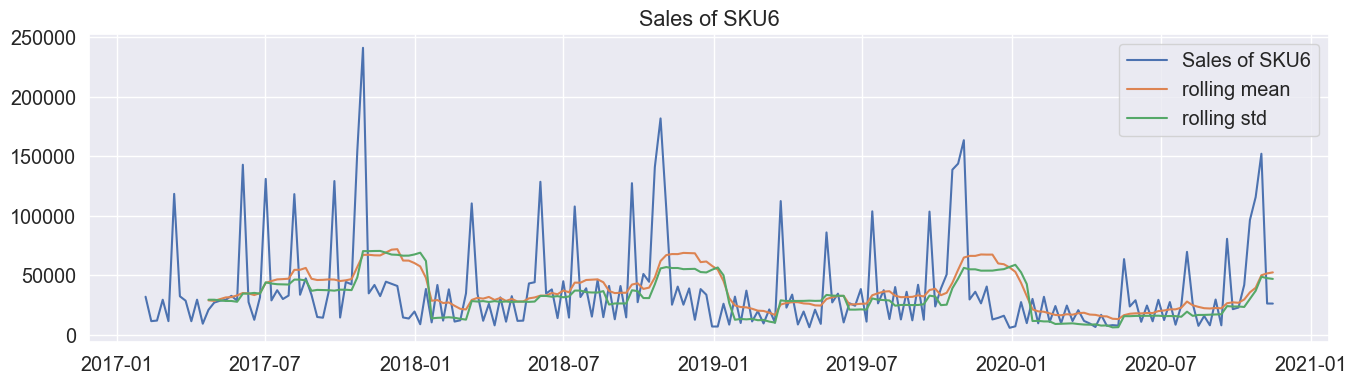

In [40]:
pd.options.display.float_format = '{:.8f}'.format
for key, sku in skus.items():
    test_stationarity(sku.Sales, "Sales of " + key.upper() )

In [41]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [42]:
for key, sku in skus.items():
    ADF_test(sku.Sales, "Sales of " + key.upper())

 > Is the Sales of SKU1 stationary ?
Test statistic = -9.083
P-value = 0.000
Critical values :
	1%: -3.463987334463603 - The data is  stationary with 99% confidence
	5%: -2.8763259091636213 - The data is  stationary with 95% confidence
	10%: -2.5746515171738515 - The data is  stationary with 90% confidence
 > Is the Sales of SKU2 stationary ?
Test statistic = -15.166
P-value = 0.000
Critical values :
	1%: -3.463987334463603 - The data is  stationary with 99% confidence
	5%: -2.8763259091636213 - The data is  stationary with 95% confidence
	10%: -2.5746515171738515 - The data is  stationary with 90% confidence
 > Is the Sales of SKU3 stationary ?
Test statistic = -3.145
P-value = 0.023
Critical values :
	1%: -3.4668001583460613 - The data is not stationary with 99% confidence
	5%: -2.8775552336674317 - The data is  stationary with 95% confidence
	10%: -2.5753075498128246 - The data is  stationary with 90% confidence
 > Is the Sales of SKU4 stationary ?
Test statistic = -6.287
P-value = 

From the Dickey Fuller test, we know that the Sales data at for all 6 SKUs are stationary.

### 2.6 Periodogram

In [43]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("52W") / pd.Timedelta("1W")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
        ],
        rotation=90,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

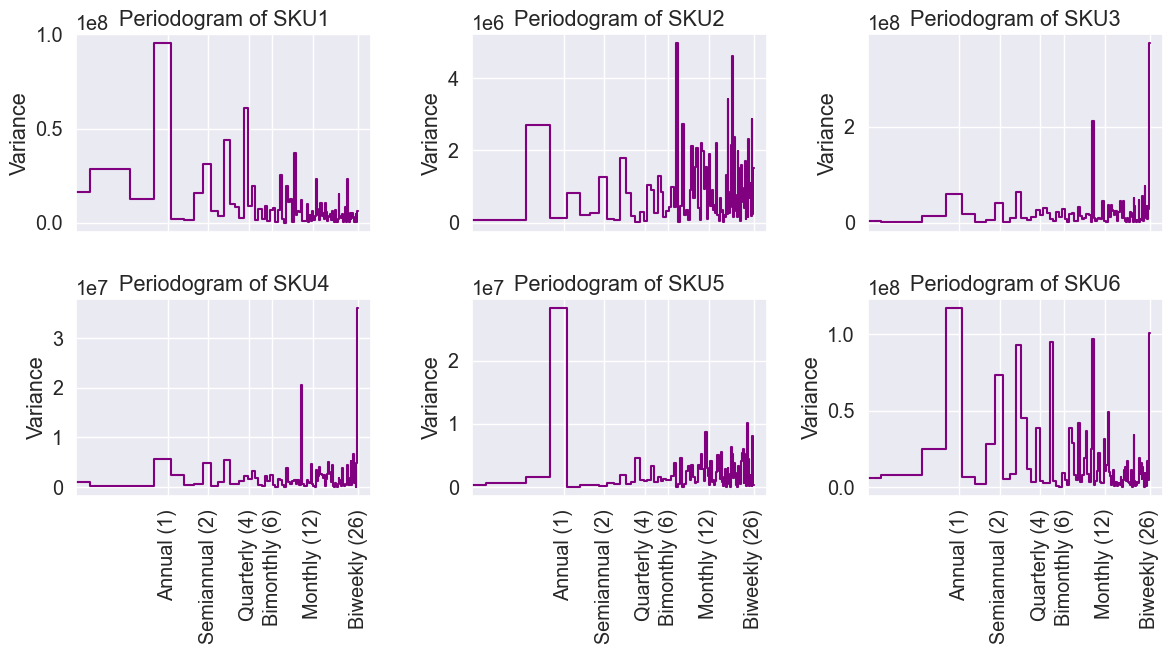

In [44]:
fig, ax = plt.subplots(2, 3, figsize = (12, 7), sharex = True)
for i, (key, sku) in enumerate(skus.items()):
    plot_periodogram(sku.Sales, ax = ax[i//3][i%3])
    ax[i//3][i%3].set_title(f"Periodogram of {key.upper()}")
    
fig.tight_layout()

## 3. Features engineering

### 3.1 Lagging

In [78]:
# function to create a lagplot
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

# functions to plot the lagplot
def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig


C:\Users\study\.conda\envs\durhampj\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


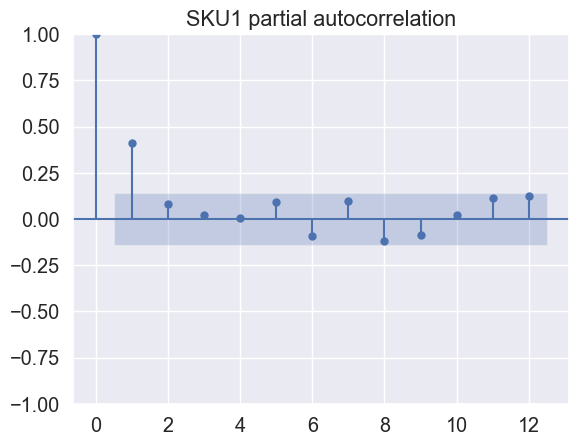

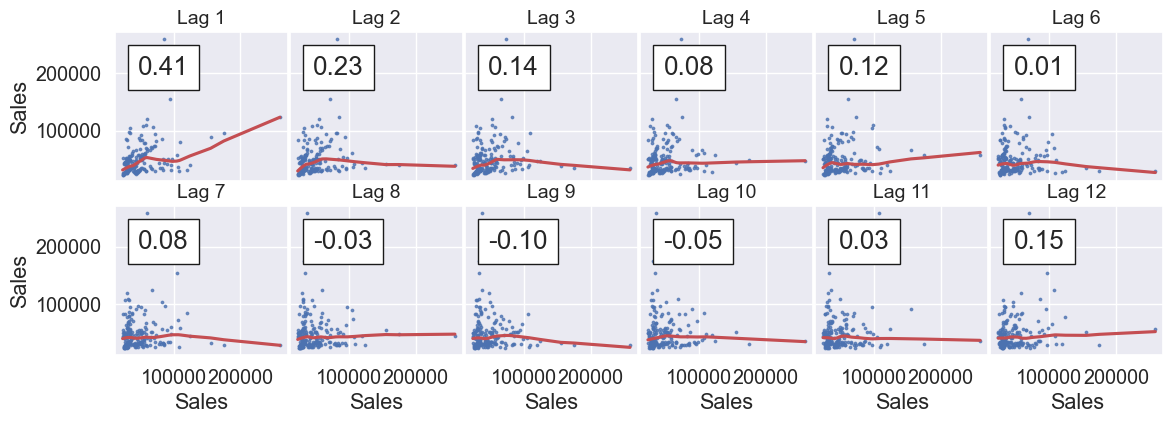

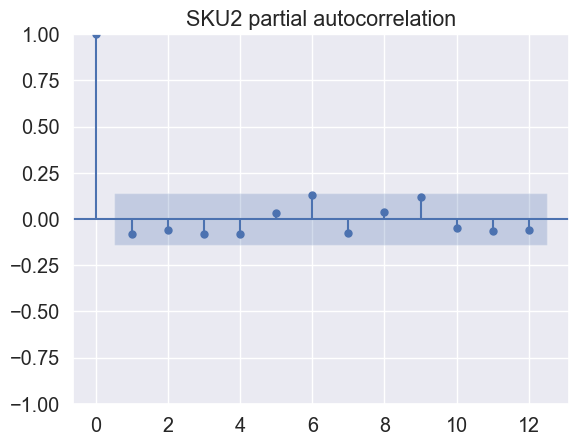

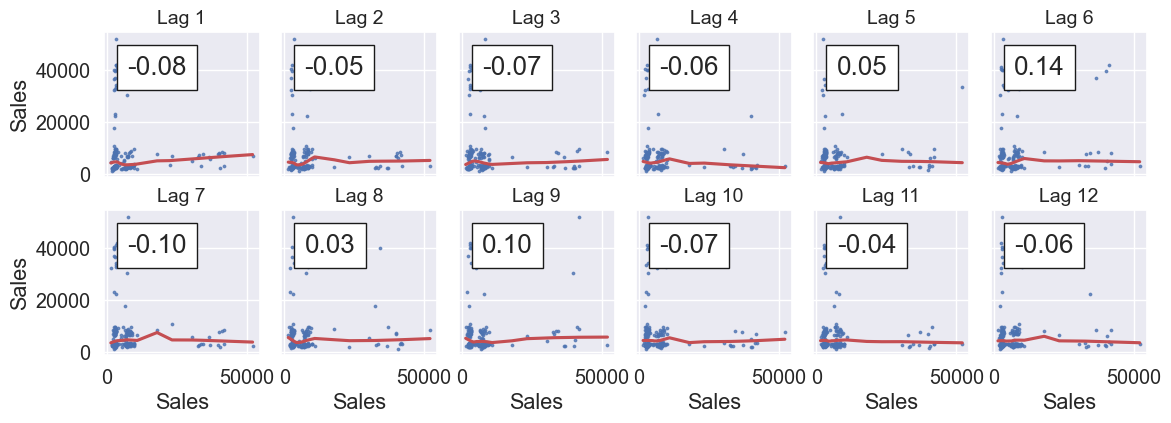

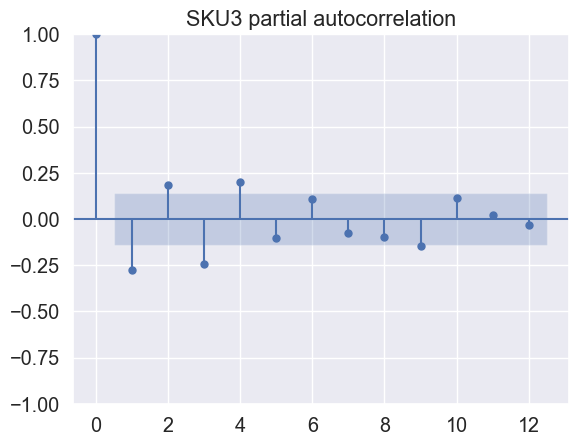

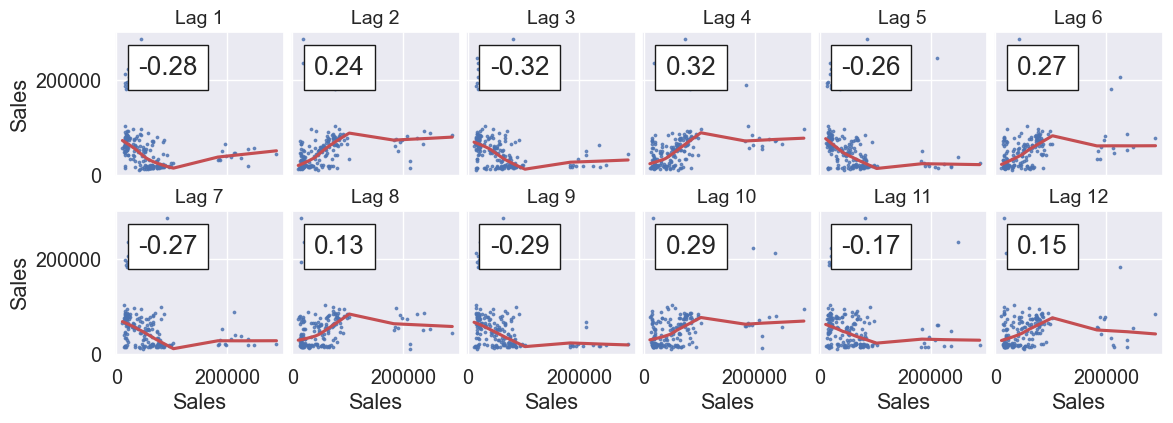

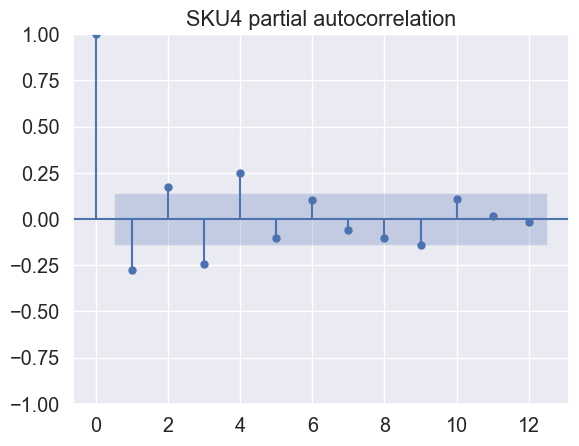

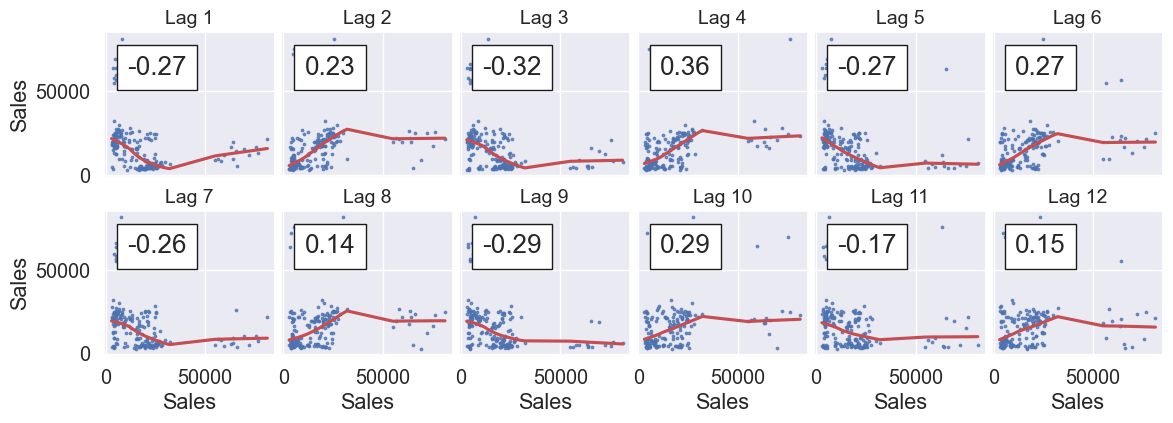

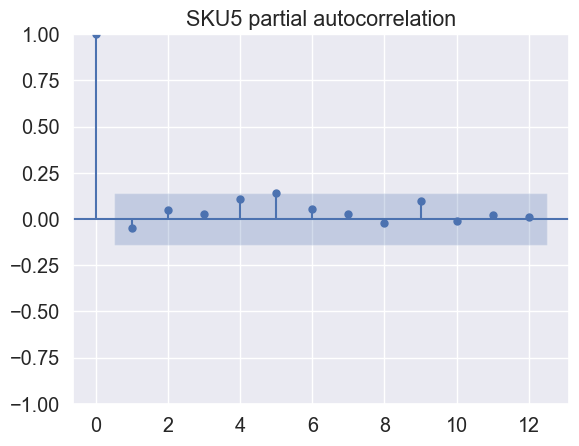

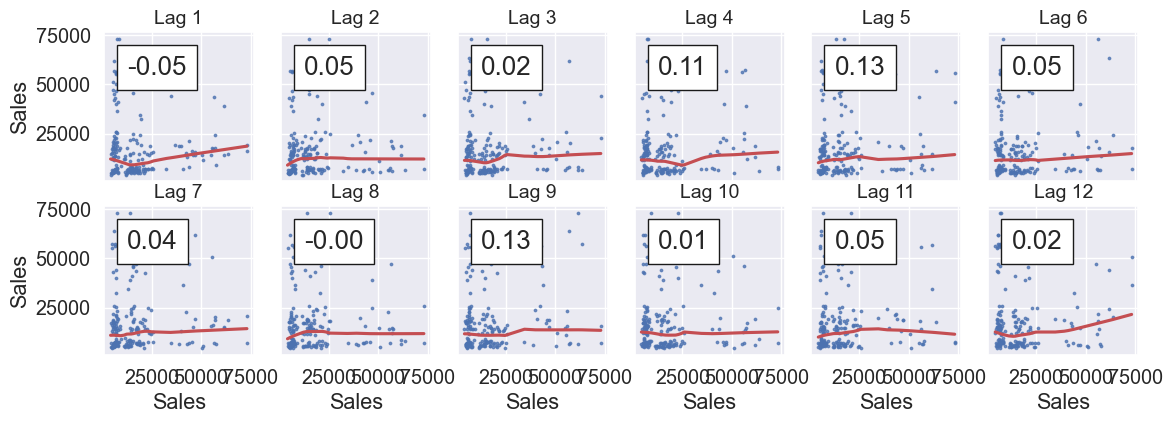

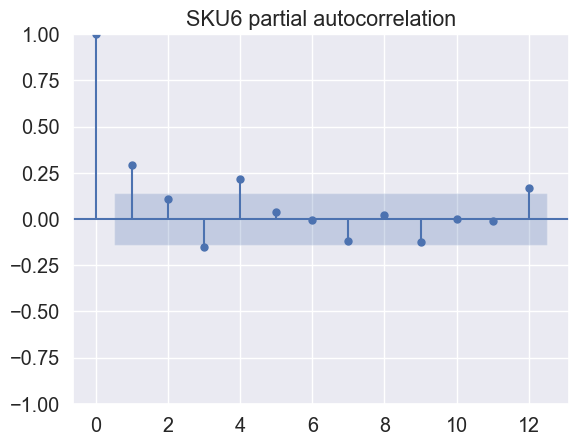

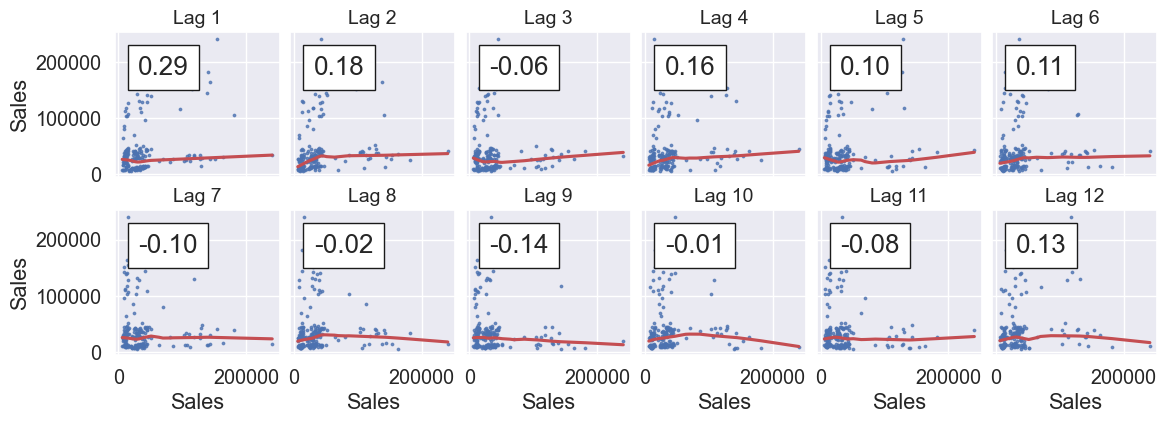

In [79]:
from statsmodels.graphics.tsaplots import plot_pacf
for key, sku in skus.items():
    _ = plot_pacf(sku.Sales, lags=12, title = f"{key.upper()} partial autocorrelation")
    _ = plot_lags(sku.Sales, lags=12, nrows=2)
    
   

In [83]:
# function to make lags
def make_lags(ts, lags):
    X = pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)
    X = X.fillna(0.0)
    return X

In [146]:
# skus['sku1'] = skus['sku1'].merge(make_lags(skus['sku1'].Sales, 1), left_index = True, right_index = True)

# skus['sku3'] = skus['sku3'].merge(make_lags(skus['sku3'].Sales, 4), left_index = True, right_index = True)

# skus['sku4'] = skus['sku4'].merge(make_lags(skus['sku4'].Sales, 4), left_index = True, right_index = True)

# skus['sku6'] = skus['sku6'].merge(make_lags(skus['sku6'].Sales, 1), left_index = True, right_index = True)



### 3.2 Train test split

In [156]:
def train_val_split(skus):
    X_train_skus = {}
    X_val_skus = {}
    y_train_skus = {}
    y_val_skus = {}

    for key, sku in skus.items():

        y = sku.Sales
        X = sku.drop(['Sales', 'Product'], axis = 1)
        size = int(len(X)*0.7)


        X_train, X_val, y_train, y_val =  X[:size], X[size:], y[:size], y[size:]

        X_train_skus[key] = X_train
        X_val_skus[key] = X_val
        y_train_skus[key] = y_train
        y_val_skus[key] = y_val
    return X_train_skus, X_val_skus, y_train_skus, y_val_skus
    



In [157]:
X_train_skus, X_val_skus, y_train_skus, y_val_skus = train_val_split(skus)

### 3.3 Trend and seasonality features

In [158]:
# function to add the trend and seasonality feature to the data
def add_trend_n_season(df_train, df_val, order=0, seasonal = False, fourier = None):
    from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
#     fourier = CalendarFourier(freq="A", order=10)
    if fourier:
        dp = DeterministicProcess(
            index=df_train.index,
            constant=True,               
            order=order,                     
            seasonal=seasonal, 
            additional_terms=[fourier],
            drop=True,                 
        )
    else:
        dp = DeterministicProcess(
            index=df_train.index,
            constant=True,               
            order=order,                     
            seasonal=seasonal, 
#             additional_terms=[fourier],
            drop=True,                 
        )
    ts_train = dp.in_sample()
    X_train = pd.merge(df_train, ts_train, left_index=True, right_index = True)
    
    ts_val = dp.out_of_sample(steps=len(df_val), forecast_index = df_val.index)
    X_val = pd.merge(df_val, ts_val, left_index=True, right_index = True)
    return X_train, X_val

## 4. Model training

### 4.1 Linear Regression

In [159]:
modified_train = {}
modified_val = {}

for key, train_sku in X_train_skus.items():
    val_sku = X_val_skus[key]
    modified_train[key], modified_val[key] = add_trend_n_season(train_sku, val_sku, 0)
    


In [162]:
def plot_forcast(key, y, X_train, y_train, X_val, y_val, ax=None):
    from sklearn.metrics import mean_squared_error
    
    model = LinearRegression(fit_intercept=False)
    _ = model.fit(X_train, y_train)
    y_pred = pd.Series(model.predict(X_train), index=y_train.index)
    y_fore = pd.Series(model.predict(X_val), index=y_val.index)
    if ax is None:
        _, ax = plt.subplots()
        
    error = mean_squared_error(y_val, y_fore)
    title = f"{key} | MSE: {round(error)}"
        
    ax = y.plot(color='k', style='.',title= title, ax= ax, label = 'Sales')
    ax = y_pred.plot(color='b', ax= ax, label= 'Trend and Seasonal')
    ax = y_fore.plot(label="Forecast", ax = ax, color = 'r')
    
    _ = ax.legend()
    
        
    
    return ax

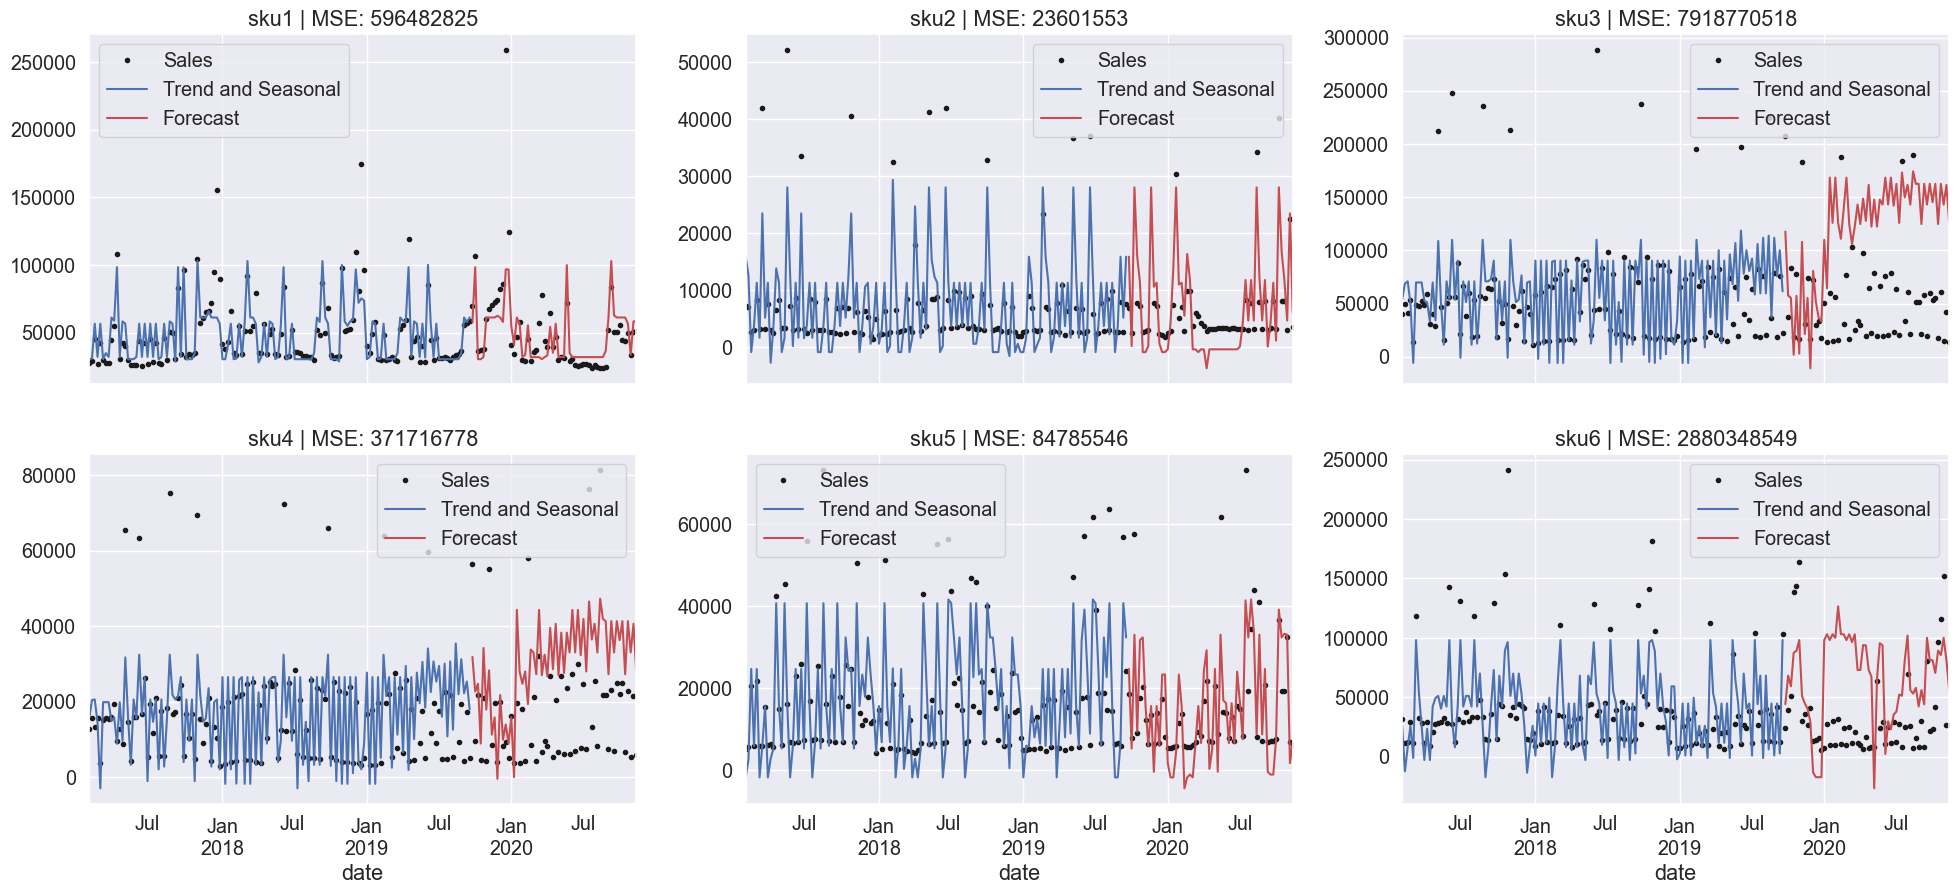

In [163]:
fig, ax = plt.subplots(2,3 , figsize=(24,10), sharex = True)

for i, (key, X_train_sku) in enumerate(modified_train.items()):
    
    X_val_sku = modified_val[key]
    y_train_sku = y_train_skus[key]
    y_val_sku = y_val_skus[key]
    plot_forcast(key, skus[key].Sales, 
                 X_train_sku, 
                y_train_sku,
                X_val_sku,
                y_val_sku,
                ax = ax[i // 3][i % 3])
    


### 4.2 Hyperparameters tuning

In [164]:
modified_train_tune = {}
modified_val_tune = {}

